In [ ]:
import torch 
import numpy as np
from utils.siglip_experiment import *
from matplotlib.pyplot import plt
%load_ext autoreload
%autoreload 2

# Fixed Large Temperature

In [33]:
torch.manual_seed(50)

n_classes = 100
dim = 10
n_epochs = int(1e4)
device_str = 'cuda' if torch.cuda.is_available() else 'cpu'

initial_relative_biases = [-1,-1/2, 0,1/2,1]
bias_is_trainable = False
temperature_is_trainable = False
# Test a range of temperatures
t = 100  # 20 evenly spaced temperatures between 10 and 50
final_losses = []
final_temps = []
final_embeddings = []

print(f"Using device: {device_str}")
print(f"Running experiments with: n_classes={n_classes}, dim={dim}, n_epochs={n_epochs}")

for rb in initial_relative_biases:
    print(f"\nTesting temperature: {rb:.2f}")
    
    experiment = SigLIPExperiment(
        n_classes=n_classes,
        dim=dim,
        n_epochs=n_epochs,
        device=device_str
    )

    U_final, V_final, criterion_final, losses_history = experiment.train(
        relative_bias=rb,
        temperature=t,
        trainable_temp=temperature_is_trainable,
        trainable_bias=bias_is_trainable
    )
    
    final_loss = losses_history[-1]
    final_temp = criterion_final.get_temperature()
    
    final_losses.append(final_loss)
    final_temps.append(final_temp.detach().item())  # Detach and convert to Python scalar
    

    print(f"Final Loss: {final_loss:.4f}")
    print(f"Final Temperature: {final_temp:.4f}")

    final_embeddings.append((U_final, V_final))
    #experiment.plot_inner_product_gap(U_final, V_final)
    #plt.savefig(f'logs/inner_product_gap_{rb:.2f}.png')

[autoreload of siglip_experiment failed: Traceback (most recent call last):
  File "/Users/iliyas/Library/Python/3.12/lib/python/site-packages/IPython/extensions/autoreload.py", line 276, in check
    superreload(m, reload, self.old_objects)
  File "/Users/iliyas/Library/Python/3.12/lib/python/site-packages/IPython/extensions/autoreload.py", line 475, in superreload
    module = reload(module)
             ^^^^^^^^^^^^^^
  File "/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/importlib/__init__.py", line 131, in reload
    _bootstrap._exec(spec, module)
  File "<frozen importlib._bootstrap>", line 866, in _exec
  File "<frozen importlib._bootstrap_external>", line 990, in exec_module
  File "<frozen importlib._bootstrap_external>", line 1128, in get_code
  File "<frozen importlib._bootstrap_external>", line 1058, in source_to_code
  File "<frozen importlib._bootstrap>", line 488, in _call_with_frames_removed
  File "/Users/iliyas/Documents/UROP/SigLip Theory/Represent

Using device: cpu
Running experiments with: n_classes=100, dim=10, n_epochs=10000

Testing temperature: -1.00
[100/10000]  loss=18.2241  T=100.0000  rb=-1.0000
[200/10000]  loss=18.2241  T=100.0000  rb=-1.0000
[300/10000]  loss=18.2241  T=100.0000  rb=-1.0000
[400/10000]  loss=18.2241  T=100.0000  rb=-1.0000
[500/10000]  loss=18.2241  T=100.0000  rb=-1.0000
[600/10000]  loss=18.2241  T=100.0000  rb=-1.0000
[700/10000]  loss=18.2241  T=100.0000  rb=-1.0000
[800/10000]  loss=18.2241  T=100.0000  rb=-1.0000
[900/10000]  loss=18.2241  T=100.0000  rb=-1.0000
[1000/10000]  loss=18.2241  T=100.0000  rb=-1.0000
[1100/10000]  loss=18.2241  T=100.0000  rb=-1.0000
[1200/10000]  loss=18.2241  T=100.0000  rb=-1.0000
[1300/10000]  loss=18.2241  T=100.0000  rb=-1.0000
[1400/10000]  loss=18.2241  T=100.0000  rb=-1.0000
[1500/10000]  loss=18.2241  T=100.0000  rb=-1.0000
[1600/10000]  loss=18.2241  T=100.0000  rb=-1.0000
[1700/10000]  loss=18.2241  T=100.0000  rb=-1.0000
[1800/10000]  loss=18.2241  T=10

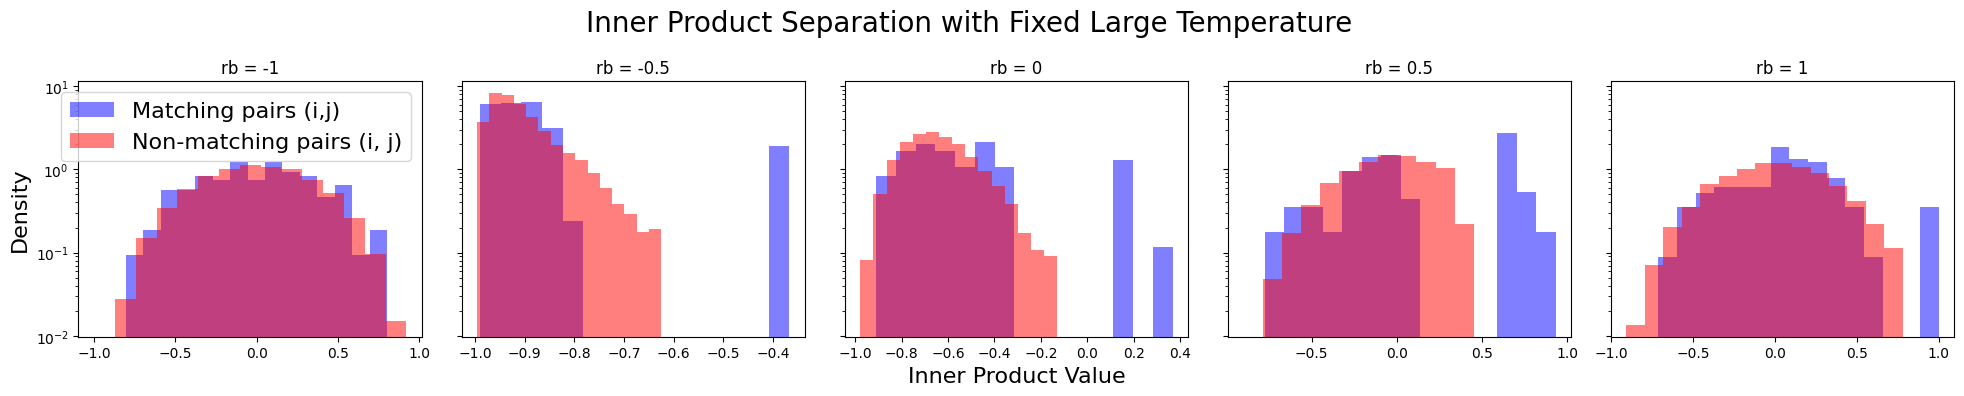

In [34]:
fig, axes = plt.subplots(1, 5, figsize=(20, 4), sharey=True)

fig.suptitle('Inner Product Separation with Fixed Large Temperature', fontsize=20)
titles = ["rb = "+str(rb) for rb in initial_relative_biases]
for i, ax in enumerate(axes):

    U_final, V_final = final_embeddings[i]
    inner_products = torch.matmul(U_final, V_final.t())
        # Get matching pairs (diagonal elements)
    matching_pairs = torch.diag(inner_products).detach().cpu().numpy()
        # Get non-matching pairs (off-diagonal elements)
    mask = ~torch.eye(n_classes, dtype=bool, device=device_str)
    non_matching_pairs = inner_products[mask].detach().cpu().numpy()

        # Create histogram plot
    ax.hist(matching_pairs, bins= 15, alpha=0.5, label='Matching pairs (i,j)', color='blue', density=True, log = True)
    ax.hist(non_matching_pairs, bins=15, alpha=0.5, label='Non-matching pairs (i, j)', color='red', density=True, log = True)

    
    ax.set_title(titles[i])

    
    if i == 0:
        ax.set_ylabel('Density', fontsize = 16)
        ax.legend(fontsize= 16)
    if i == 2:
        ax.set_xlabel('Inner Product Value', fontsize = 16)
    
plt.tight_layout()

plt.savefig("logs/ablationfixedlargetemperature.png",dpi=300, bbox_inches='tight')
plt.show()

# Trainable Temperature 

In [35]:
torch.manual_seed(50)

n_classes = 100
dim = 10
n_epochs = int(1e4)
device_str = 'cuda' if torch.cuda.is_available() else 'cpu'

initial_relative_biases = [-1,-1/2, 0,1/2,1]
bias_is_trainable = False
temperature_is_trainable = True
# Test a range of temperatures
t = 10  # 20 evenly spaced temperatures between 10 and 50
final_losses = []
final_temps = []
final_embeddings = []

print(f"Using device: {device_str}")
print(f"Running experiments with: n_classes={n_classes}, dim={dim}, n_epochs={n_epochs}")

for rb in initial_relative_biases:
    print(f"\nTesting temperature: {rb:.2f}")
    
    experiment = SigLIPExperiment(
        n_classes=n_classes,
        dim=dim,
        n_epochs=n_epochs,
        device=device_str
    )

    U_final, V_final, criterion_final, losses_history = experiment.train(
        relative_bias=rb,
        temperature=t,
        trainable_temp=temperature_is_trainable,
        trainable_bias=bias_is_trainable
    )
    
    final_loss = losses_history[-1]
    final_temp = criterion_final.get_temperature()
    
    final_losses.append(final_loss)
    final_temps.append(final_temp.detach().item())  # Detach and convert to Python scalar
    

    print(f"Final Loss: {final_loss:.4f}")
    print(f"Final Temperature: {final_temp:.4f}")

    final_embeddings.append((U_final, V_final))
    #experiment.plot_inner_product_gap(U_final, V_final)
    #plt.savefig(f'logs/inner_product_gap_{rb:.2f}.png')

Using device: cpu
Running experiments with: n_classes=100, dim=10, n_epochs=10000

Testing temperature: -1.00
[100/10000]  loss=0.7017  T=6.5261  rb=-1.0000
[200/10000]  loss=0.6932  T=6.5188  rb=-1.0000
[300/10000]  loss=0.6931  T=6.5188  rb=-1.0000
[400/10000]  loss=0.6931  T=6.5188  rb=-1.0000
[500/10000]  loss=0.6931  T=6.5188  rb=-1.0000
[600/10000]  loss=0.6931  T=6.5188  rb=-1.0000
[700/10000]  loss=0.6931  T=6.5188  rb=-1.0000
[800/10000]  loss=0.6931  T=6.5188  rb=-1.0000
[900/10000]  loss=0.6931  T=6.5188  rb=-1.0000
[1000/10000]  loss=0.6931  T=6.5188  rb=-1.0000
[1100/10000]  loss=0.6931  T=6.5188  rb=-1.0000
[1200/10000]  loss=0.6931  T=6.5188  rb=-1.0000
[1300/10000]  loss=0.6931  T=6.5188  rb=-1.0000
[1400/10000]  loss=0.6931  T=6.5188  rb=-1.0000
[1500/10000]  loss=0.6931  T=6.5188  rb=-1.0000
[1600/10000]  loss=0.6931  T=6.5188  rb=-1.0000
[1700/10000]  loss=0.6931  T=6.5188  rb=-1.0000
[1800/10000]  loss=0.6931  T=6.5188  rb=-1.0000
[1900/10000]  loss=0.6931  T=6.5188

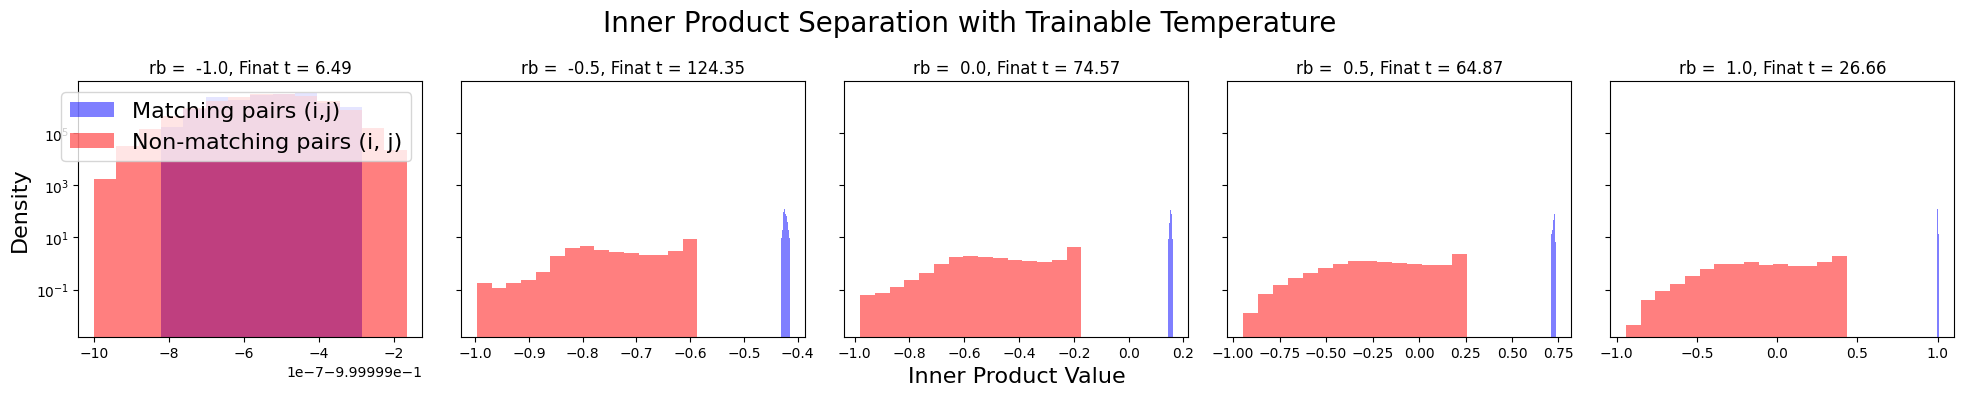

In [36]:
fig, axes = plt.subplots(1, 5, figsize=(20, 4), sharey=True)

fig.suptitle('Inner Product Separation with Trainable Temperature', fontsize=20)
titles = [f"rb =  {rb:.1f}, Finat t = {final_temps[i]:.2f}" for i,rb in enumerate(initial_relative_biases)]
for i, ax in enumerate(axes):

    U_final, V_final = final_embeddings[i]
    inner_products = torch.matmul(U_final, V_final.t())
        # Get matching pairs (diagonal elements)
    matching_pairs = torch.diag(inner_products).detach().cpu().numpy()
    if i>0:
        matching_pairs = matching_pairs + .002*np.random.normal(size = matching_pairs.shape)
        # Get non-matching pairs (off-diagonal elements)
    mask = ~torch.eye(n_classes, dtype=bool, device=device_str)
    non_matching_pairs = inner_products[mask].detach().cpu().numpy()

        # Create histogram plot
    ax.hist(matching_pairs, bins= 15, alpha=0.5, label='Matching pairs (i,j)', color='blue', density=True, log = True)
    ax.hist(non_matching_pairs, bins=15, alpha=0.5, label='Non-matching pairs (i, j)', color='red', density=True, log = True)

    
    ax.set_title(titles[i])

    
    if i == 0:
        ax.set_ylabel('Density', fontsize = 16)
        ax.legend(fontsize= 16)
    if i == 2:
        ax.set_xlabel('Inner Product Value', fontsize = 16)
    
plt.tight_layout()
plt.savefig("logs/ablationtrainablelargetemperature.png",dpi=300, bbox_inches='tight')
plt.show()


<function matplotlib.pyplot.show(close=None, block=None)>

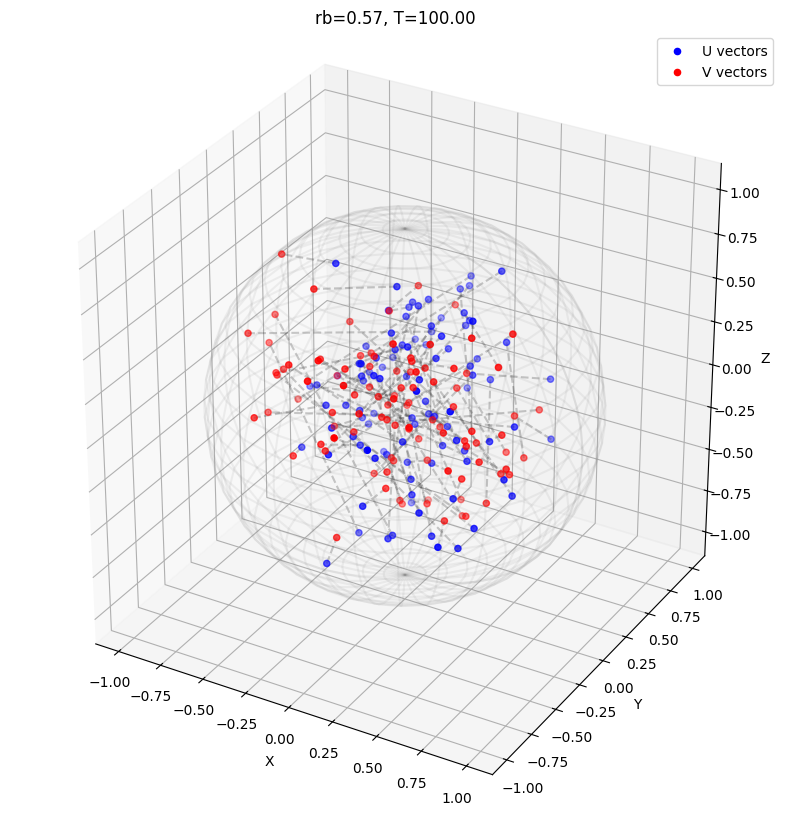

In [18]:
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111, projection='3d')
experiment.plot_vectors(
        U_final,
        V_final,
        criterion_final,
        ax=ax
    )
ax.legend()
plt.show